# Visualization in Spatial Data Analysis

Having covered the formal representation of spatial data we now turn to a series
of methods for the _visualization_ of spatial data. We continue on with the
airbnb data that we explored in the previous notebook. Here we use it to
describe a common type of geovizualization used for area unit data with numeric
attributes, namely _choropleth maps_.

## Choropleth Maps ##

Choropleth maps play a prominent role in spatial data science.
The word choropleth stems from the root "choro" meaning "region". As such
choropleth maps are appropriate for areal unit data where each observation
combines a value of an attribute and a polygon. Choropleth maps derive from an
earlier era where cartographers faced technological constraints that precluded
the use of unclassed maps where each unique attribute value could be represented
by a distinct symbol. Instead, attribute values were grouped into a smaller
number of classes with each class being associated with a unique symbol that was
in turn applied to all polygons with attribute values falling in the class.

Although today these technological constraints are no longer binding, and
unclassed mapping is feasible, there are still good reasons for adopting a
classed approach. Chief among these is to reduce the cognitive load involved in
parsing the complexity of an unclassed map. A choropleth map reduces this
complexity by drawing upon statistical and visualization theory to provide an
effective representation of the spatial distribution of the attribute values
across the areal units. 

The effectiveness of a choropleth map will be a
function of the choice of classification scheme together with the color or
symbolization strategy adopted. In broad terms, the classification scheme
defines the number of classes as well as the rules for assignment, while the
symbolization should convey information about the value differentiation across
the classes.

## Data classification ##

Data classification considers the problem of a
partitioning of the attribute values into mutually exclusive and exhaustive
groups. The precise manner in which this is done will be a function of the
measurement scale of the attribute in question. For quantitative attributes
(ordinal, interval, ratio scales) the classes will have an explicit ordering.
More formally, the classification problem is to define class boundaries such
that
$$
c_j < y_i \le  c_{j+1} \ \forall y_i \in C_{j+1}
$$
where $y_i$ is the
value of the attribute for spatial location $i$, $j$ is a class index, and $c_j$
represents the lower bound of interval $j$.

Different classification schemes
obtain from their definition of the class boundaries. The choice of the
classification scheme should take into consideration the statistical
distribution of the attribute values.


### Attribute Distribution (a-spatial) ###

In [2]:
import pandas as pd
import geopandas as gpd
import libpysal as lp
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import contextily as ctx
import shapely.geometry as geom
%matplotlib inline

In [10]:
df = gpd.read_file('../data/neighborhoods.gpkg')
listings = gpd.read_file('../data/listings.gpkg')
listings['price'] = listings.price.str.replace('$', '').str.replace(',','_').astype(float)
# was created in previous notebook with df.to_file('data/neighborhoods.gpkg')

In [11]:
df.head()

,hood_id,hood_group,geometry
0,78739,None,"(POLYGON ((-97.890016 30.209412, -97.889286 30..."
1,78754,None,"(POLYGON ((-97.636577 30.402658, -97.637538000..."
2,78732,None,"(POLYGON ((-97.87302800000001 30.438064, -97.8..."
3,78737,None,"(POLYGON ((-98.018756 30.241665, -98.016169 30..."
4,78756,None,"(POLYGON ((-97.72792200000001 30.329055, -97.7..."


In [12]:
median_price = gpd.sjoin(listings[['price', 'geometry']], df, op='within')\
                  .groupby('index_right').price.median()
df['median_pri'] = median_price.values

In [13]:
df['median_pri'].fillna((df['median_pri'].mean()), inplace=True)

In [14]:
import seaborn as sbn

We can use `seaborn` to visualize the statistical distribution of the median
price of listings across neighborhoods:

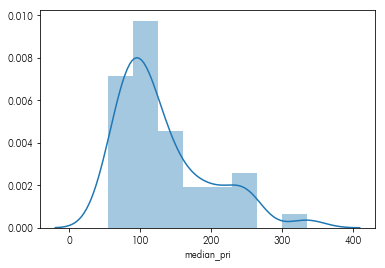

In [15]:
sbn.distplot(df['median_pri'])

The `distplot` combines a histogram with a kernel density. Both reflect a
right-skewed distribution, not uncommon for housing rents, or urban income
distributions.

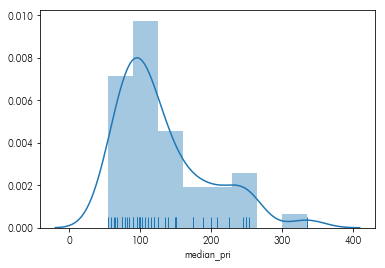

In [16]:
sbn.distplot(df['median_pri'], rug=True)

Adding the `rug` argument provides additional insight as to the distribution of
specific observations across the price range.

The histogram and density give us a sense of the "value" distribution. From a
spatial data science perspective, we are also interested in the "spatial"
distribution of these values. 


### Spatial Distribution - Geovisualization Revisited ###

Since we have a GeoDataFrame we can call the `plot` method to generate a default
choropleth:

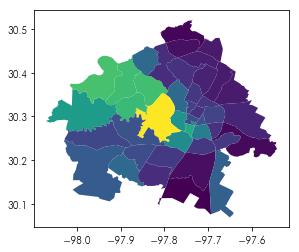

In [17]:
df.plot(column='median_pri')

Without prior knowledge of this urban area, interpretation of the visualization
is challenging. We can improve things through some additional options:

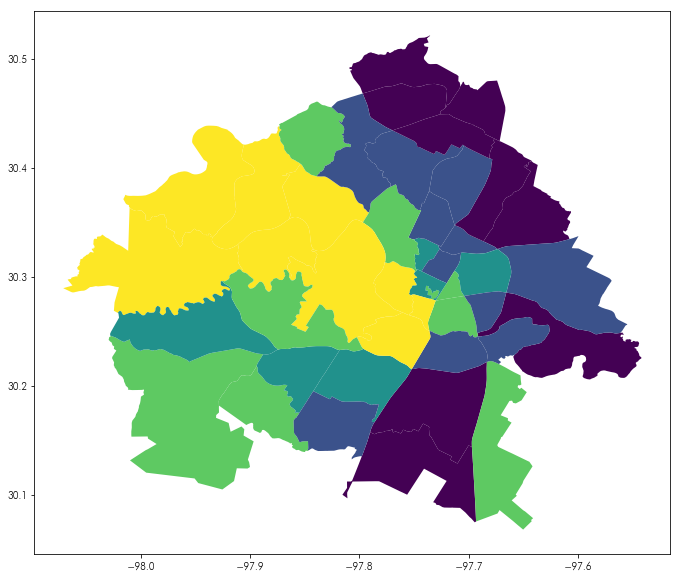

In [18]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='median_pri', scheme='Quantiles', ax=ax)

We've bumped up the size of the map and added an option for `scheme`.
The `Quantiles` scheme is one map classification method that GeoPanda includes,
which are in turn based on PySAL.

This has improved the visualization, but there are still questions. For example,
how many different colors (hues) do we see? A choropleth map uses different hues
to distinguish different value classes, in a similar sense to the bins of a
histogram separating observations with different values.


Adding a `legend` argument reveals the nature of the classes:

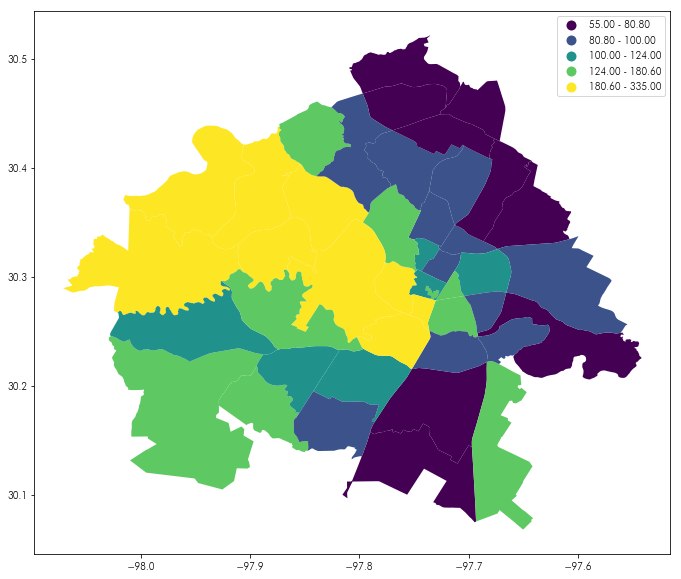

In [19]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='median_pri', scheme='Quantiles',  legend=True, ax=ax)

The five classes in the legend are the quintiles for the attribute distribution.
If we instead would like to see the quartile classification, we set a new option `k=4`

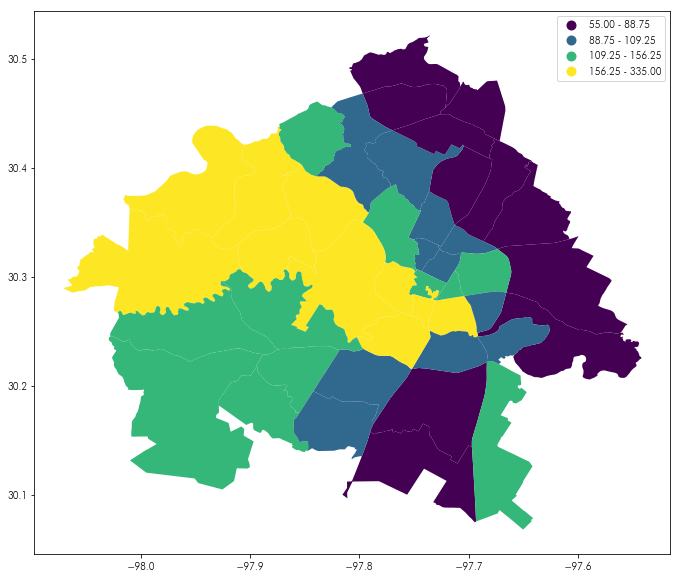

In [20]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='median_pri', scheme='Quantiles', k=4, legend=True, ax=ax)

In addition to changing the number of classes, the color map that defines the
hues for the classes can be changed:

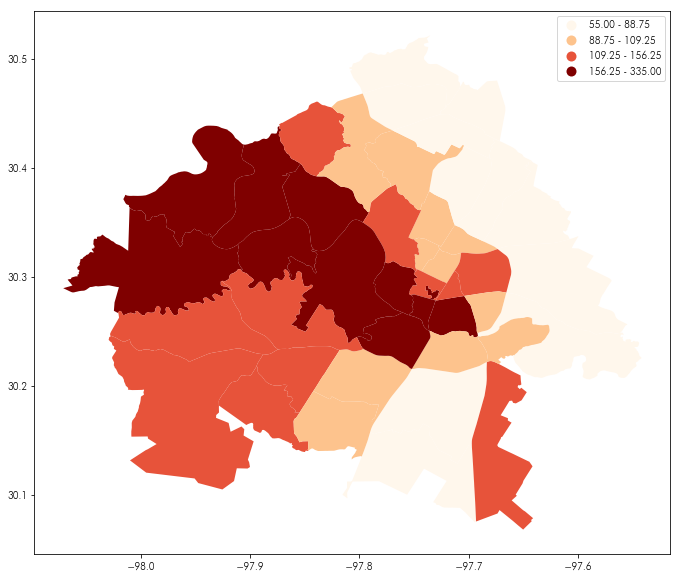

In [21]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='median_pri', scheme='Quantiles', k=4, legend=True, ax=ax, 
        cmap='OrRd')

Both the color ramp and the classification scheme can have substantial impacts
on the resulting visualization. GeoPandas makes it straightforward to explore
these dimensions. For example, changing the color ramp results in:

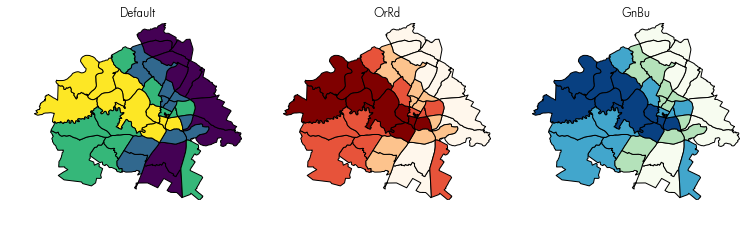

In [22]:
f,ax = plt.subplots(1,3,figsize=(3.16*4,4))
df.plot(column='median_pri', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=4)
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Default")
df.plot(column='median_pri', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='OrRd', k=4)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("OrRd")
df.plot(column='median_pri', ax=ax[2], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=4)
ax[2].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[2].set_title("GnBu")
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

Alternatively we can change the classification scheme:

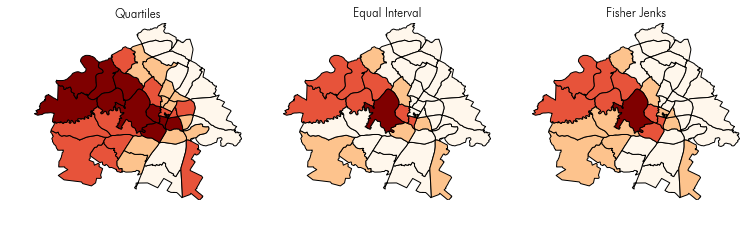

In [23]:
f,ax = plt.subplots(1,3,figsize=(3.16*4,4))
df.plot(column='median_pri', ax=ax[0], edgecolor='k',
        scheme="quantiles", cmap='OrRd', k=4)
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Quartiles")
df.plot(column='median_pri', ax=ax[1], edgecolor='k',
        scheme='equal_interval', cmap='OrRd', k=4)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Equal Interval")
df.plot(column='median_pri', ax=ax[2], edgecolor='k',
       scheme='fisher_jenks', cmap='OrRd', k=4)
ax[2].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[2].set_title("Fisher Jenks")
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

GeoPandas supports a subset of the map classification schemes that are available
in PySAL. The selected ones have a similar function signature that allowed for a
simple soft dependency. Since the initial implementation, PySAL has begun a
major refactoring, and as part of this the classification scheme have been moved
into their own package: `mapclassify`. We can explore some of the other
classifiers within this package:

In [24]:
import mapclassify as mc

`mapclassify` offers a number of schemes for choropleth mapping:

In [25]:
mc.CLASSIFIERS

('Box_Plot',
 'Equal_Interval',
 'Fisher_Jenks',
 'Fisher_Jenks_Sampled',
 'HeadTail_Breaks',
 'Jenks_Caspall',
 'Jenks_Caspall_Forced',
 'Jenks_Caspall_Sampled',
 'Max_P_Classifier',
 'Maximum_Breaks',
 'Natural_Breaks',
 'Quantiles',
 'Percentiles',
 'Std_Mean',
 'User_Defined')

Equal intervals splits the data range into $k$ equal-width bins:

In [26]:
y = df['median_pri']
ea5 = mc.Equal_Interval(y, k=5)

This creates a classification object using equal intervals for the
classification:

In [27]:
ea5

              Equal Interval              
 
 Lower            Upper              Count
          x[i] <= 111.000               23
111.000 < x[i] <= 167.000               10
167.000 < x[i] <= 223.000                5
223.000 < x[i] <= 279.000                5
279.000 < x[i] <= 335.000                1

and, among its attributes are the bin ids each observation is classified into:

In [28]:
ea5.yb

array([1, 0, 3, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 2, 0, 1,
       3, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 4, 0, 1, 3, 0, 0, 1, 0, 0, 3, 3])

Quantiles, which we also saw from within the GeoPandas df, has a similar
interface:

In [29]:
q5 = mc.Quantiles(y, k=5)
q5

                Quantiles                 
 
 Lower            Upper              Count
          x[i] <=  80.800                9
 80.800 < x[i] <= 100.000               11
100.000 < x[i] <= 124.000                6
124.000 < x[i] <= 180.600                9
180.600 < x[i] <= 335.000                9

In [30]:
q5.yb

array([3, 0, 4, 3, 2, 0, 1, 3, 4, 0, 1, 0, 0, 2, 3, 1, 3, 1, 3, 4, 0, 2,
       4, 2, 3, 1, 0, 1, 1, 4, 0, 2, 1, 4, 1, 3, 4, 2, 1, 3, 1, 0, 4, 4])

While equal-width bins have the same width, quantiles attempt to have the same
number of observations assigned to each of the $k$ classes. A close look at the
result for the quintiles reveals this is not exact for the price data. The
reason for this is that there are substantially less than $n$ unique
observations:

In [31]:
y.shape

(44,)

In [32]:
np.unique(y).shape

(34,)

So care must be taken with regard to quantiles.

### Selecting a classification based on fit ###

Choropleth mapping can be used for different purposes. The most common is to
select a classification that provides a balance between maximizing the
differences between observations in each bin, and minimizing the intra-bin heterogeneity.

The classifiers in PySAL have underlying measures of fit for this purpose, but
it is important to keep in mind these should only be used for classifiers with
the same number of classes. One 

One such measure is the the `absolute deviation around class
medians` (ADCM). Let's use this to compare all k=5 classifiers:

In [33]:
q5 = mc.Quantiles(y, k=5)
ei5 = mc.Equal_Interval(y, k=5)
mb5 = mc.Maximum_Breaks(y, k=5)
fj5 = mc.Fisher_Jenks(y, k=5)
fits = [c.adcm for c in [q5, ei5, mb5, fj5]]
fits

[540.0, 528.5, 773.5, 481.5]

As expected, Fisher Jenks is the optimal classifer. 


### Outlier Detection ###
Another application of choropleth mapping is to identify either data errors
or extreme values. There are a number of classifers that can be used to detect _value outliers_:

In [34]:
ht = mc.HeadTail_Breaks(y)
ht

             HeadTail_Breaks              
 
 Lower            Upper              Count
          x[i] <= 131.830               28
131.830 < x[i] <= 201.906                9
201.906 < x[i] <= 252.429                5
252.429 < x[i] <= 294.500                1
294.500 < x[i] <= 335.000                1

In [35]:
std = mc.Std_Mean(y)
std

                 Std_Mean                 
 
 Lower            Upper              Count
          x[i] <=   2.410                0
  2.410 < x[i] <=  67.120                5
 67.120 < x[i] <= 196.539               31
196.539 < x[i] <= 261.249                7
261.249 < x[i] <= 335.000                1

In [36]:
bp = mc.Box_Plot(y)
bp

                 Box Plot                 
 
 Lower            Upper              Count
          x[i] <= -12.500                0
-12.500 < x[i] <=  88.750               11
 88.750 < x[i] <= 109.250               11
109.250 < x[i] <= 156.250               11
156.250 < x[i] <= 257.500               10
257.500 < x[i] <= 335.000                1

### Using mapclassify with GeoPandas ###

Although only a subset of the PySAL classifiers are directly accessible from
within GeoPandas, it is possible to combine external classifiers with GeoPandas:

In [37]:
bp

                 Box Plot                 
 
 Lower            Upper              Count
          x[i] <= -12.500                0
-12.500 < x[i] <=  88.750               11
 88.750 < x[i] <= 109.250               11
109.250 < x[i] <= 156.250               11
156.250 < x[i] <= 257.500               10
257.500 < x[i] <= 335.000                1

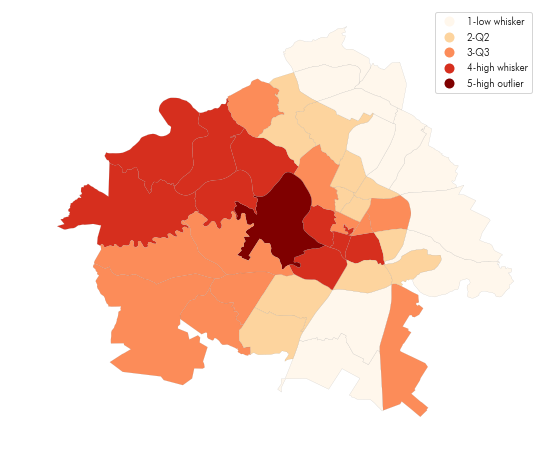

In [38]:
labels = ['0-low outlier', '1-low whisker',
          '2-Q2', '3-Q3', '4-high whisker', '5-high outlier']
bpl = [ labels[b] for b in bp.yb ]

f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=bpl).plot(column='cl', categorical=True, \
                                      k=4, cmap='OrRd', linewidth=0.1, ax=ax,\
                                      edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()
